In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt 
import glob as gb
import efficientnet.tfkeras as efn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
import os
import hashlib

from PIL import Image
import albumentations as A

/bin/bash: /home/enjoy/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/enjoy/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/enjoy/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/enjoy/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


/bin/bash: /home/enjoy/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/enjoy/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


2023-05-25 02:46:30.433526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 02:46:30.835628: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 02:46:31.675978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/enjoy/miniconda3/envs/tf/lib/:/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-05-25 02:46:31.676532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could n

In [2]:
print(tf.__version__)

2.10.1


In [3]:
tf.config.set_visible_devices([], 'GPU')

# GPU usage
Making sure that *GPU* is used when using *GPU* accelator turned on as it seems not to work sometimes

> Notebook was runed using: GPU P100

In [4]:
gpus = tf.config.list_physical_devices('GPU'); print(gpus)
if len(gpus)==1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else: strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-25 02:46:33.060943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 02:46:33.112765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 02:46:33.113317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 02:46:33.115486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Using auto mixed precision as it seems to improve speed of *GPU*

In [5]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

# Defining load_image functions and paths

In [6]:
def load_image(filename):
    image = load_img("./data/img_sz_256/" + filename)
    plt.imshow(image) 

def load_random_image(filenames):
    sample = random.choice(filenames)
    image = load_img("./data/img_sz_256/" + sample)
    plt.imshow(image)           
    
def load_image_for_augmentation(image_path):
    image = cv2.imread(image_path)
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    image = np.array(image)
    return image    

# adding path we will use in this nothebook 
def format_resized_image_path_gcs(st):
    return GCS_DS_PATH + '/img_sz_256/' + st
def format_tpu_path(st):
    return './data/img_sz_256/' + st

# Loading train dataframe and defining image paths

In [7]:
train_df = pd.read_csv("./train.csv")

In [8]:
RESIZED_IMAGE_PATH = "./data/img_sz_256/"

# Explaining ***plant-pathology*** and ***plant-pathology*** dataset

Firstly we analyze dataframe and it labels distribution

In [9]:
train_df.labels.value_counts()

labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: count, dtype: int64

/tmp/ipykernel_17503/3054290964.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


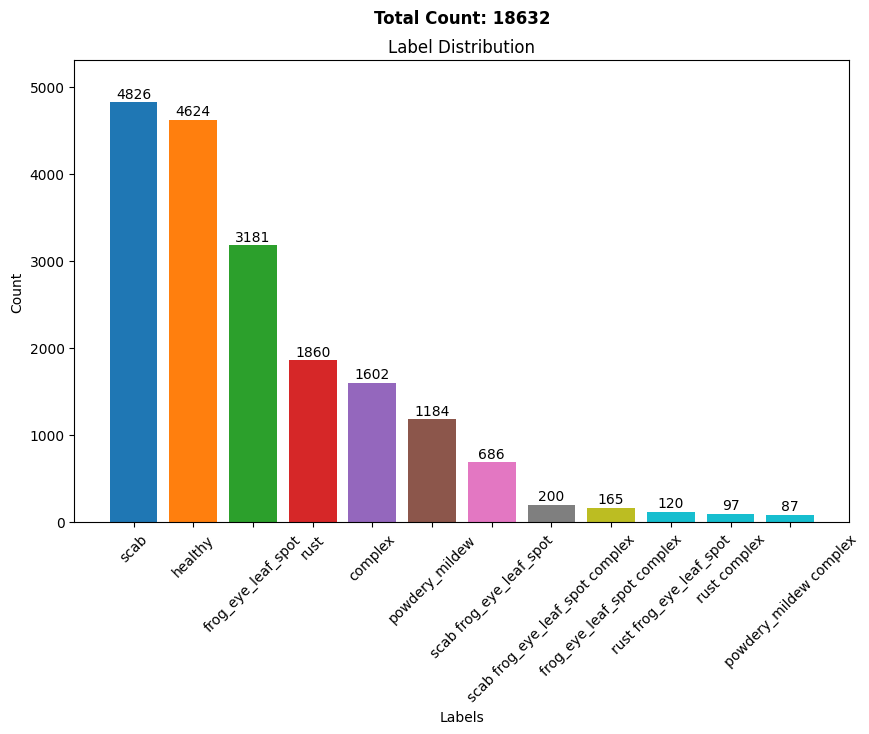

In [10]:
# Calculate the count of each label
label_counts = train_df['labels'].value_counts()

# Define a colormap for assigning colors to labels
colormap = plt.cm.get_cmap('tab10')

# Get the number of unique labels
num_labels = len(label_counts)

# Generate an array of colors based on the colormap
colors = [colormap(i) for i in range(num_labels)]

# Plot the label distribution with colored bars
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)

# Add count labels above the bars
for i, count in enumerate(label_counts):
    plt.text(i, count + 50, str(count), ha='center')

# Add a line below the total count
total_count = label_counts.sum()
plt.axhline(total_count, color='black', linestyle='--', alpha=0.5)

# Add total count of all labels above the title with increased font size and bold style
plt.text(0.5, 1.08, f'Total Count: {total_count}', transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')

# Calculate the maximum count for setting the y-axis limit
max_count = max(label_counts)
y_limit = max_count + max_count * 0.1  # Add some padding

plt.ylim(top=y_limit)  # Set the y-axis limit to accommodate the line

plt.show()

We try to detect duplicates in dataframe and delete them.

In [11]:
initial_length = len(train_df)

# create dictionary to store hashes and paths
hashes = {}

duplicates = []
originals = []

# loop over rows in the dataframe
for index, row in train_df.iterrows():
    # get the filename of the image
    filename = row['image']
    
    # compute the hash of the image
    with open(os.path.join(RESIZED_IMAGE_PATH, filename), 'rb') as f:
        hash = hashlib.md5(f.read()).hexdigest()
    
    # check if hash already exists in dictionary
    if hash in hashes:
        duplicates.append(filename)
        
        originals.append(hashes[hash])
        # delete duplicate row from dataframe
        train_df.drop(index, inplace=True)
    else:
        # add hash and path to dictionary
        hashes[hash] = filename

# print number of duplicates found
print(f"Number of duplicates found: {initial_length-len(hashes)}")

Number of duplicates found: 27


# Loading original and duplicated images found

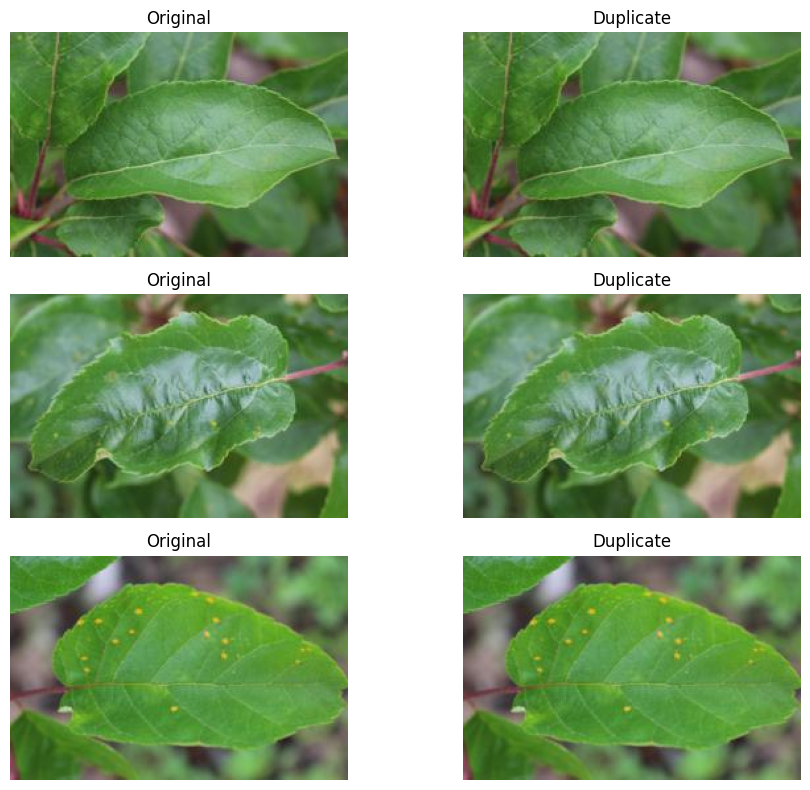

In [12]:
# List of image filenames
image_filenames = [ originals[0], duplicates[0],
                    originals[1], duplicates[1],
                    originals[2], duplicates[2]]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Iterate over the image filenames and corresponding subplots
for i, (image_filename, ax) in enumerate(zip(image_filenames, axes.flatten())):
    # Load the image
    image = plt.imread(format_tpu_path(image_filename))
    
    # Show the image in the subplot
    ax.imshow(image)
    ax.axis('off')

    # Set subplot title
    if i % 2 == 0:
        title = 'Original'
    else:
        title = 'Duplicate'
    ax.set_title(title)
# Adjust the layout of subplots to avoid overlapping
plt.tight_layout()

# Display the figure
plt.show()

Now we can compare how two grafs look like: before deleting duplicates and after

In [13]:
train_df.labels.value_counts()

labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1844
complex                            1593
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         95
powdery_mildew complex               87
Name: count, dtype: int64

/tmp/ipykernel_17503/3054290964.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


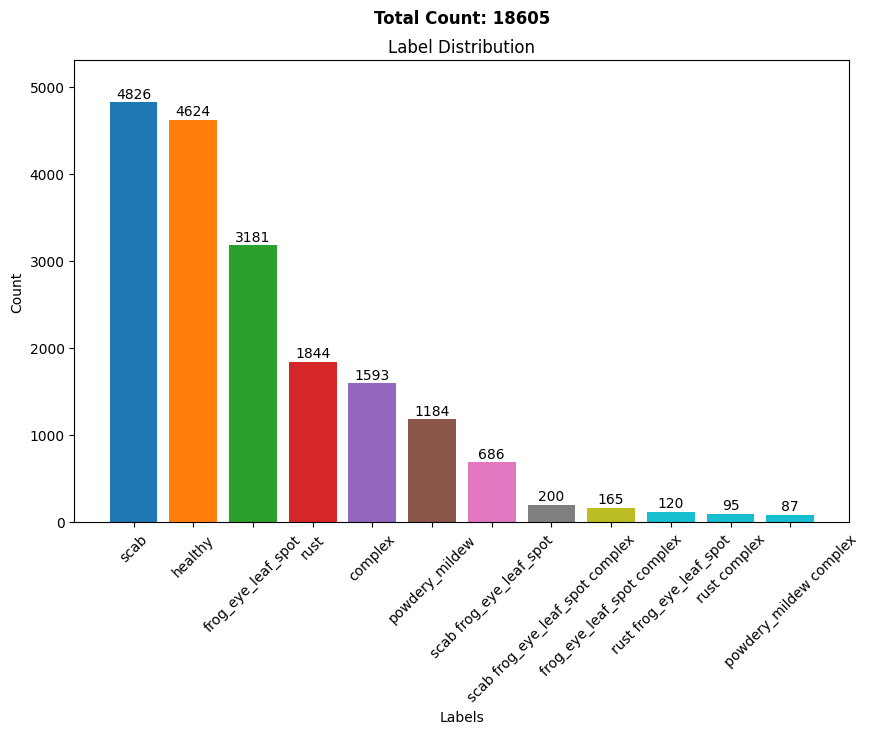

In [14]:
# Calculate the count of each label
label_counts = train_df['labels'].value_counts()

# Define a colormap for assigning colors to labels
colormap = plt.cm.get_cmap('tab10')

# Get the number of unique labels
num_labels = len(label_counts)

# Generate an array of colors based on the colormap
colors = [colormap(i) for i in range(num_labels)]

# Plot the label distribution with colored bars
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)

# Add count labels above the bars
for i, count in enumerate(label_counts):
    plt.text(i, count + 50, str(count), ha='center')

# Add a line below the total count
total_count = label_counts.sum()
plt.axhline(total_count, color='black', linestyle='--', alpha=0.5)

# Add total count of all labels above the title with increased font size and bold style
plt.text(0.5, 1.08, f'Total Count: {total_count}', transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')

# Calculate the maximum count for setting the y-axis limit
max_count = max(label_counts)
y_limit = max_count + max_count * 0.1  # Add some padding

plt.ylim(top=y_limit)  # Set the y-axis limit to accommodate the line

plt.show()

# Performing **One Hot Encoding** on labels. <br>
**One Hot Encoding** converts categorical data into numeric values.

As we see from two graphs above that there is 12 labels but we can also notice that this classification task requires multilabel approach. 

As we approach multilable classification we need to find unique labels in dataframe labels column and separate them to their own column.

After we have different columns we need to convert categorical labels to numerical values to be able to use *'binary_crossentropy'* loss function

In [15]:
# Extract the labels column from the dataframe and store it in a list
labels = train_df['labels'].tolist()

# Create a set of unique labels
unique_labels = set()

# Iterate through each label in the list of labels and add it to the set of unique labels
for label in labels:
    unique_labels.update(label.split())

# Print the number of unique labels
print(unique_labels, "suma:", len(unique_labels))

{'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'rust', 'healthy', 'complex'} suma: 6


In [16]:
train_df

image                           labels
0      800113bb65efe69e.jpg                          healthy
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2      80070f7fb5e2ccaa.jpg                             scab
3      80077517781fb94f.jpg                             scab
4      800cbf0ff87721f8.jpg                          complex
...                     ...                              ...
18627  fffb900a92289a33.jpg                          healthy
18628  fffc488fa4c0e80c.jpg                             scab
18629  fffc94e092a59086.jpg                             rust
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot
18631  fffe472a0001bd25.jpg                          healthy

[18605 rows x 2 columns]

In [17]:
# Select the six most common unique labels
common_labels = [label[0] for label in pd.Series(labels).str.split(expand=True).stack().value_counts()[:6].items()]
# Create a MultiLabelBinarizer object with the six common labels
mlb = MultiLabelBinarizer(classes=common_labels)

# Transform the labels into a binary matrix with one-hot encoding for the six common labels
label_matrix = mlb.fit_transform(train_df['labels'].str.split())

# Create a new dataframe with the one-hot encoded labels
label_df = pd.DataFrame(label_matrix, columns=common_labels)

# fixes train_df row number error
train_df.reset_index(drop=True, inplace=True)
label_df.reset_index(drop=True, inplace=True)

# Concatenate the new label dataframe with the original dataframe
new_df = pd.concat([train_df, label_df], axis=1)

# Drop the original labels column from the new dataframe
train_df = new_df.drop('labels', axis=1)
train_df.head()

image  scab  healthy  frog_eye_leaf_spot  complex  rust   
0  800113bb65efe69e.jpg     0        1                   0        0     0  \
1  8002cb321f8bfcdf.jpg     1        0                   1        1     0   
2  80070f7fb5e2ccaa.jpg     1        0                   0        0     0   
3  80077517781fb94f.jpg     1        0                   0        0     0   
4  800cbf0ff87721f8.jpg     0        0                   0        1     0   

   powdery_mildew  
0               0  
1               0  
2               0  
3               0  
4               0

/tmp/ipykernel_17503/3711420710.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


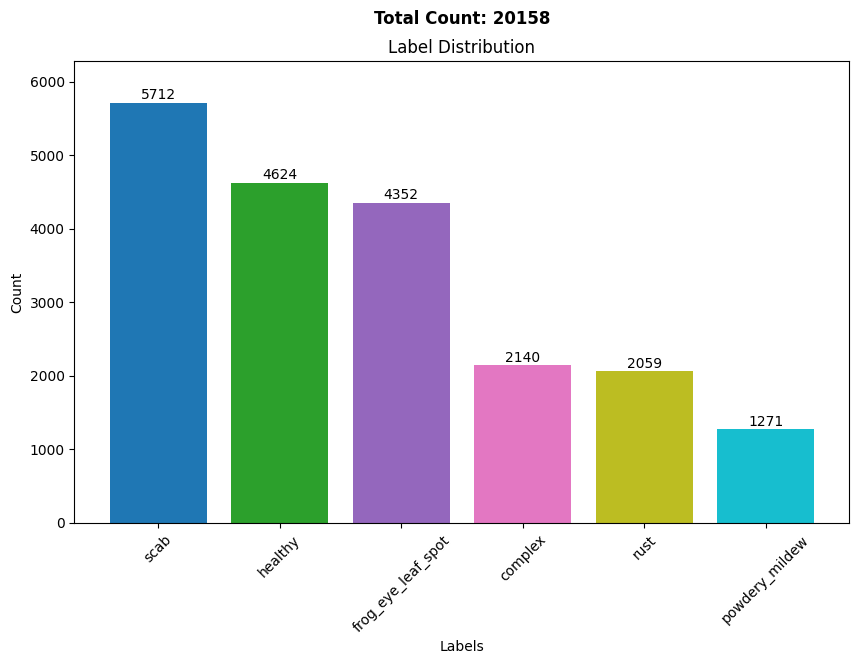

In [18]:
# Calculate the sum of each label column
label_counts = train_df.iloc[:, 1:].sum()

# Define a colormap for assigning colors to labels
colormap = plt.cm.get_cmap('tab10')

# Get the number of unique labels
num_labels = len(label_counts)

# Generate an array of colors based on the colormap
colors = [colormap(i) for i in np.linspace(0, 1, num_labels)]

# Plot the label distribution with colored bars
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)

# Add count labels above the bars
for i, count in enumerate(label_counts):
    plt.text(i, count + 50, str(count), ha='center')

# Add a line below the total count
total_count = label_counts.sum()
plt.axhline(total_count, color='black', linestyle='--', alpha=0.5)

# Add total count of all labels above the title with increased font size and bold style
plt.text(0.5, 1.08, f'Total Count: {total_count}', transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')

# Calculate the maximum count for setting the y-axis limit
max_count = max(label_counts)
y_limit = max_count + max_count * 0.1  # Add some padding

plt.ylim(top=y_limit)  # Set the y-axis limit to accommodate the line

plt.show()

34# Albumentations

In [19]:
frog_eye_leaf_spot = list(train_df[train_df["frog_eye_leaf_spot"]==1].image)
rust = list(train_df[train_df["rust"]==1].image)
scab = list(train_df[train_df["scab"]==1].image)
complex = list(train_df[train_df["complex"]==1].image)
healthy = list(train_df[train_df["healthy"]==1].image)
powdery_mildew = list(train_df[train_df["powdery_mildew"]==1].image)

# Loading sample images from every class and saving them to output folder for later use

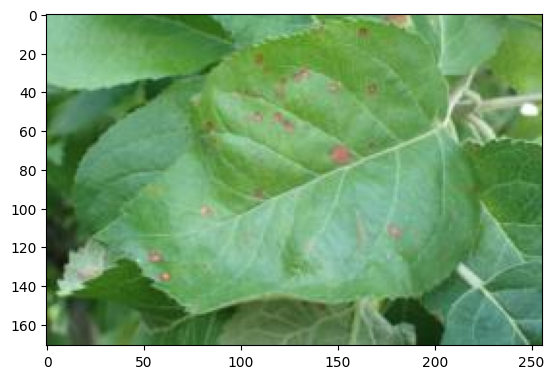

In [20]:
load_random_image(frog_eye_leaf_spot)
plt.savefig('frog_eye_leaf_spot.png')

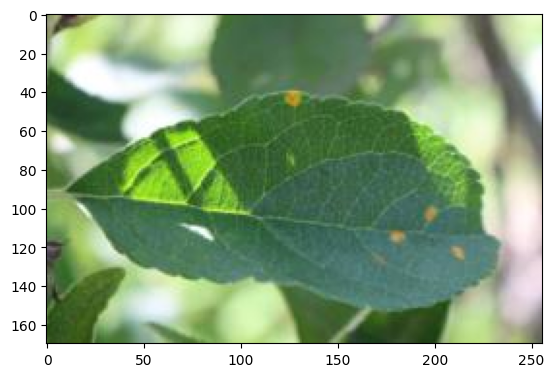

In [21]:
load_random_image(rust)
plt.savefig('rust.png')

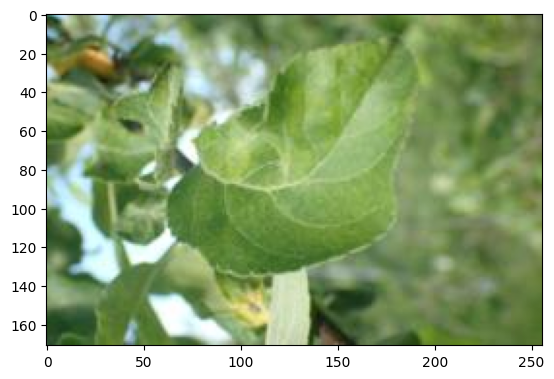

In [22]:
load_random_image(scab)
plt.savefig('scab.png')

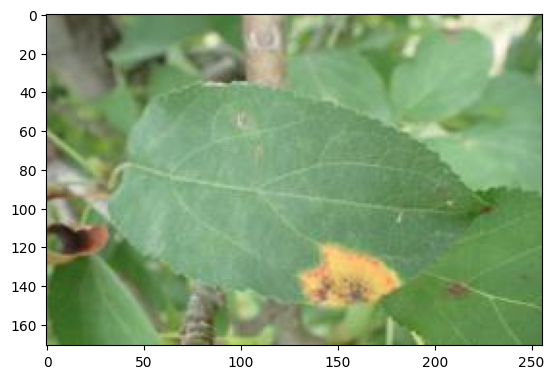

In [23]:
load_random_image(complex)
plt.savefig('complex.png')

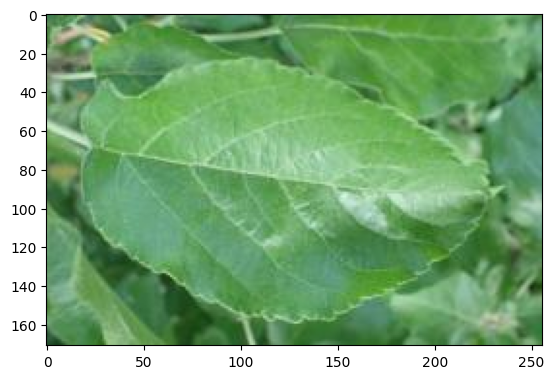

In [24]:
load_random_image(healthy)
plt.savefig('healthy.png')

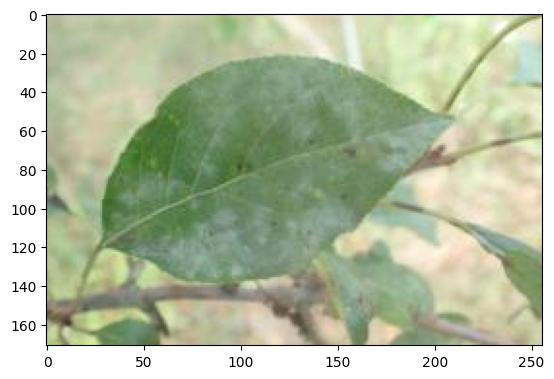

In [25]:
load_random_image(powdery_mildew)
plt.savefig('powdery_mildew.png')

# Training and validation split

In [26]:
#===============================================================
#===============================================================
# X = train_df.image.apply(format_resized_image_path_gcs).values
X = train_df.image.apply(format_tpu_path).values
y = np.float32(train_df.loc[:, 'healthy':'scab'].values)

In [27]:
df = train_df

# Get the hot encoded label columns
label_cols = [col for col in df.columns if not col.startswith('image')]

# Split the dataframe into features (X) and labels (y)
# X = df.drop(label_cols, axis=1)
y = df[label_cols]

# Determine the size of the validation set
validation_size = 0.2

# Split the data into training and validation sets while ensuring that the label distribution is balanced in both sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size, stratify=y, random_state=25)

In [28]:
len(y_train)

14884

/tmp/ipykernel_17503/3190438435.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


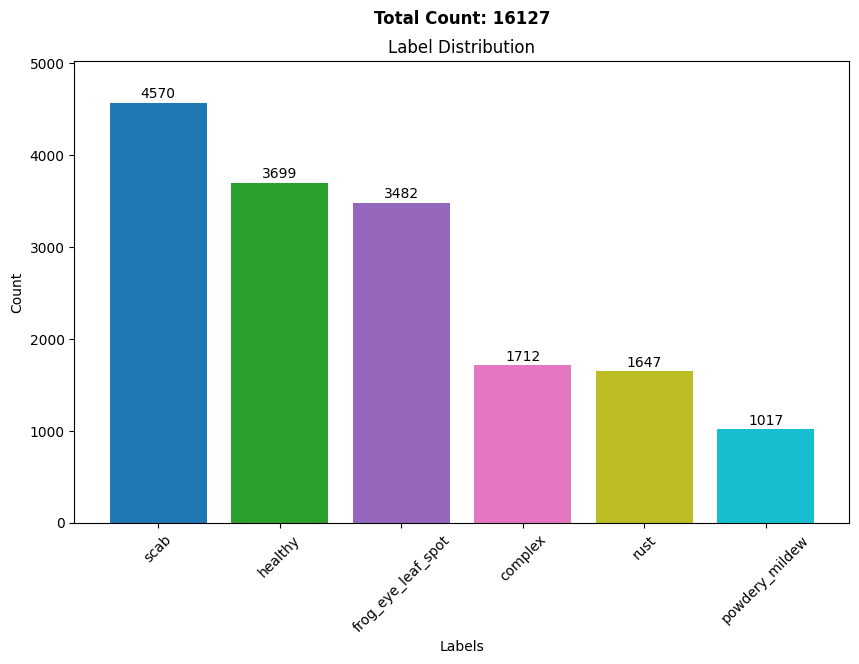

In [29]:
# Calculate the sum of each label column
label_counts = y_train.iloc[:, 0:].sum()

# Define a colormap for assigning colors to labels
colormap = plt.cm.get_cmap('tab10')

# Get the number of unique labels
num_labels = len(label_counts)

# Generate an array of colors based on the colormap
colors = [colormap(i) for i in np.linspace(0, 1, num_labels)]

# Plot the label distribution with colored bars
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)

# Add count labels above the bars
for i, count in enumerate(label_counts):
    plt.text(i, count + 50, str(count), ha='center')

# Add a line below the total count
total_count = label_counts.sum()
plt.axhline(total_count, color='black', linestyle='--', alpha=0.5)

# Add total count of all labels above the title with increased font size and bold style
plt.text(0.5, 1.08, f'Total Count: {total_count}', transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')

# Calculate the maximum count for setting the y-axis limit
max_count = max(label_counts)
y_limit = max_count + max_count * 0.1  # Add some padding

plt.ylim(top=y_limit)  # Set the y-axis limit to accommodate the line

plt.show()

In [30]:
arr_df = pd.DataFrame(X_train, columns=['image'])

# Reset the index of arr_df
arr_df = arr_df.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

train_df = pd.concat([arr_df, y_train], axis=1)

In [31]:
def cutout_image(image):
    image_array = np.array(image)
    augmented_array = A.CoarseDropout(max_holes=8, max_height=12, max_width=12, always_apply=True)(image=image_array)['image']

    return Image.fromarray(augmented_array)

def elastic_transform_image(image):
    image_array = np.array(image)
    augmented_array = A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, always_apply=True)(image=image_array)['image']

    return Image.fromarray(augmented_array)

def gaussian_noise_image(image):
    image_array = np.array(image)
    augmented_array = A.GaussNoise(var_limit=(15.0, 60.0), always_apply=True)(image=image_array)['image']

    return Image.fromarray(augmented_array)

In [32]:
train_df

image  scab  healthy   
0      ./data/img_sz_256/c5e54ec7f45a81c2.jpg     1        0  \
1      ./data/img_sz_256/bd99c88ccce6944b.jpg     0        0   
2      ./data/img_sz_256/8813470f3a7faa2e.jpg     0        0   
3      ./data/img_sz_256/d4d2225087a277f7.jpg     1        0   
4      ./data/img_sz_256/df6070b067766662.jpg     0        0   
...                                       ...   ...      ...   
14879  ./data/img_sz_256/a48f920f8dce8fc4.jpg     0        0   
14880  ./data/img_sz_256/a7b2da2f66b04866.jpg     0        0   
14881  ./data/img_sz_256/fc82badc4f2818ea.jpg     0        0   
14882  ./data/img_sz_256/e11ac23e9672fce0.jpg     0        1   
14883  ./data/img_sz_256/aea5d6d74a4a0d1a.jpg     0        1   

       frog_eye_leaf_spot  complex  rust  powdery_mildew  
0                       0        0     0               0  
1                       0        0     1               0  
2                       0        1     0               0  
3                       0        0     0               0  
4                       1        0     0               0  
...                   ...      ...   ...             ...  
14879                   1        0     0               0  
14880                   0        1     0               0  
14881                   1        0     0               0  
14882                   0        0     0               0  
14883                   0        0     0               0  

[14884 rows x 7 columns]

In [33]:
unique_labels

{'complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'}

In [34]:
df = train_df

labels = unique_labels

# Get the counts of each label
label_counts = df[list(unique_labels)].sum()

# Calculate the number of rows to be added for each label
total_rows_added = int(len(df) * 0.03)
rows_added_per_label = (total_rows_added * label_counts / label_counts.sum()).astype(int)

# Find the maximum value
max_value = rows_added_per_label.max()

# Make the smallest value the largest
rows_added_per_label = max_value - rows_added_per_label + max_value

print(rows_added_per_label)

frog_eye_leaf_spot    156
powdery_mildew        224
scab                  126
rust                  207
healthy               150
complex               205
dtype: int64


In [35]:
# Create a new DataFrame for the augmented images
cutout_df = pd.DataFrame(columns=df.columns)
elastic_transform_df = pd.DataFrame(columns=df.columns)
gaus_df = pd.DataFrame(columns=df.columns)

In [36]:
# Create a new directory to save augmented images
cutout_dir = 'cutout_images'
os.makedirs(cutout_dir, exist_ok=True)

# Create a new directory to save augmented images
elastic_dir = 'elastic_images'
os.makedirs(elastic_dir, exist_ok=True)

# Create a new directory to save augmented images
gaus_dir = 'gaus_images'
os.makedirs(gaus_dir, exist_ok=True)

# Track the selected indices
selected_indices_set = set()

# Augment the data for each label
for label in labels:
    # Get the indices of rows with the current label
    label_indices = df[df[label] == 1].index
    # Convert label indices to a NumPy array
    label_indices = np.array(label_indices)

    # Shuffle the label indices randomly
    np.random.shuffle(label_indices)
    
    # Get the number of rows to be added for the current label
    rows_to_add = rows_added_per_label[label]

    # Select the indices for augmentation, excluding the ones already selected
    selected_indices = np.random.choice(
    np.setdiff1d(label_indices, list(selected_indices_set)),
    size=min(rows_to_add, len(label_indices)),
    replace=False)

    # Update the set of selected indices
    selected_indices_set.update(selected_indices)

    # Augment the selected rows and update the image paths in the dataframe
    for index in selected_indices:
        image_path = df.at[index, 'image']
        
        image = load_image_for_augmentation(image_path)
        
        # Apply cutout
        augmented_image = cutout_image(image)
        
        # Save the augmented image
        augmented_image_path = os.path.join(cutout_dir, f'cutout_{label}_{index}.png')
        # Save the augmented image
        augmented_image.save(augmented_image_path)

        new_row = df.iloc[index].copy()
        new_row['image'] = augmented_image_path

        # save to cutout dataframe
        cutout_df.loc[len(cutout_df)] = new_row.values
        
        
        # Apply elastic transformations
        augmented_image = elastic_transform_image(image)
        
        # Save the augmented image
        augmented_image_path = os.path.join(elastic_dir, f'elastic_{label}_{index}.png')
        augmented_image.save(augmented_image_path)

        new_row = df.iloc[index].copy()
        new_row['image'] = augmented_image_path
        
        # save to elastic dataframe
        elastic_transform_df.loc[len(elastic_transform_df)] = new_row.values
        
        
        # Apply gaussian noise
        augmented_image = gaussian_noise_image(image)
        
        # Save the augmented image
        augmented_image_path = os.path.join(gaus_dir, f'gaus_{label}_{index}.png')
        augmented_image.save(augmented_image_path)

        new_row = df.iloc[index].copy()
        new_row['image'] = augmented_image_path
        
        # save to gaus dataframe
        gaus_df.loc[len(gaus_df)] = new_row.values

# Save the cutout DataFrame to a new CSV file
augmented_dataframe_path = 'cutout_df.csv'
cutout_df.to_csv(augmented_dataframe_path, index=False)

# Save the elastic DataFrame to a new CSV file
augmented_dataframe_path = 'elastic_transform_df.csv'
elastic_transform_df.to_csv(augmented_dataframe_path, index=False)


# Save the elastic DataFrame to a new CSV file
augmented_dataframe_path = 'gaus_df.csv'
gaus_df.to_csv(augmented_dataframe_path, index=False)

In [37]:
# cutout_df = pd.read_csv("/kaggle/working/cutout_df.csv")
# elastic_transform_df =  pd.read_csv("/kaggle/working/elastic_transform_df.csv")
# gaus_df =  pd.read_csv("/kaggle/working/gaus_df.csv")

In [38]:
cutout_frog_eye_leaf_spot = list(cutout_df[cutout_df["frog_eye_leaf_spot"]==1].image)
cutout_rust = list(cutout_df[cutout_df["rust"]==1].image)
cutout_scab = list(cutout_df[cutout_df["scab"]==1].image)
cutout_complex = list(cutout_df[cutout_df["complex"]==1].image)
cutout_healthy = list(cutout_df[cutout_df["healthy"]==1].image)
cutout_powdery_mildew = list(cutout_df[cutout_df["powdery_mildew"]==1].image)

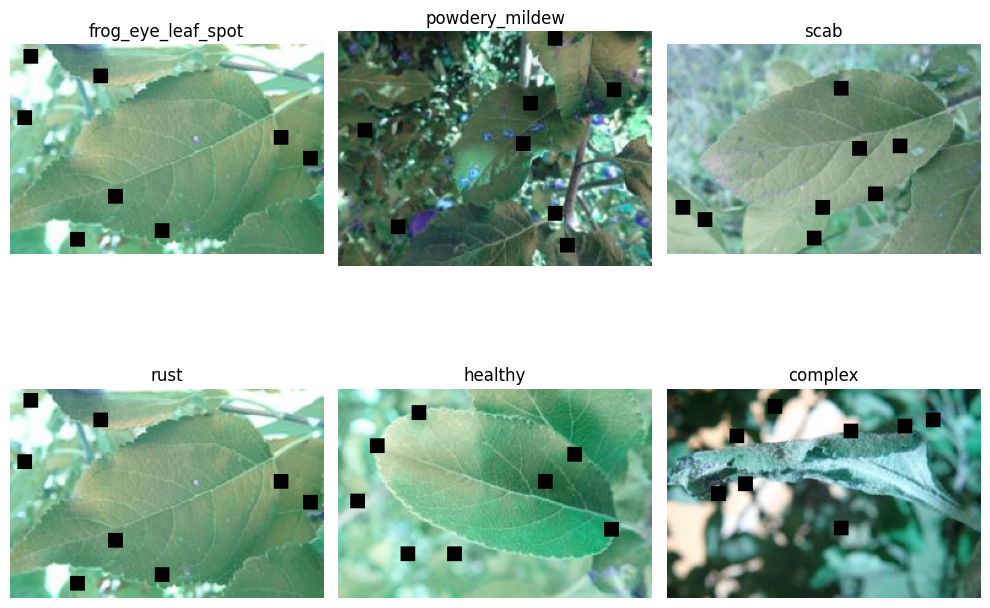

In [39]:
import matplotlib.pyplot as plt

# List of image filenames and corresponding titles
image_filenames = [cutout_frog_eye_leaf_spot[0], cutout_rust[0],
                   cutout_scab[0], cutout_complex[0],
                   cutout_healthy[0], cutout_powdery_mildew[0]]
image_titles = unique_labels

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Iterate over the image filenames, titles, and corresponding subplots
for i, (image_filename, image_title, ax) in enumerate(zip(image_filenames, image_titles, axes.flatten())):
    # Load the image
    image = plt.imread(image_filename)
    
    # Show the image in the subplot
    ax.imshow(image)
    ax.set_title(image_title)
    ax.axis('off')

# Adjust the layout of subplots to avoid overlapping
plt.tight_layout()

# Display the figure
plt.show()

In [40]:
elastic_frog_eye_leaf_spot = list(elastic_transform_df[elastic_transform_df["frog_eye_leaf_spot"]==1].image)
elastic_rust = list(elastic_transform_df[elastic_transform_df["rust"]==1].image)
elastic_scab = list(elastic_transform_df[elastic_transform_df["scab"]==1].image)
elastic_complex = list(elastic_transform_df[elastic_transform_df["complex"]==1].image)
elastic_healthy = list(elastic_transform_df[elastic_transform_df["healthy"]==1].image)
elastic_powdery_mildew = list(elastic_transform_df[elastic_transform_df["powdery_mildew"]==1].image)

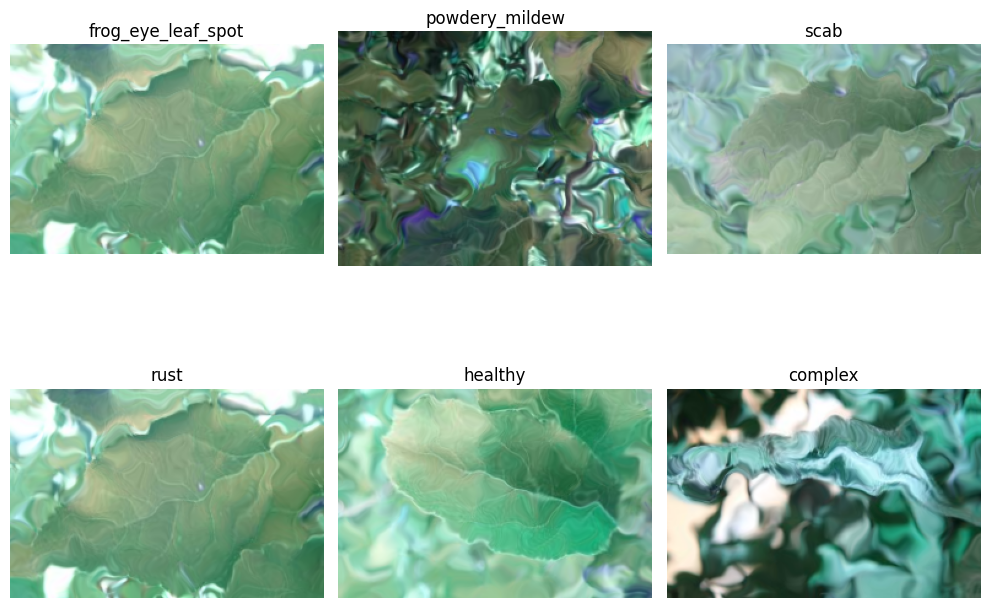

In [41]:
import matplotlib.pyplot as plt

# List of image filenames and corresponding titles
image_filenames = [elastic_frog_eye_leaf_spot[0], elastic_rust[0],
                   elastic_scab[0], elastic_complex[0],
                   elastic_healthy[0], elastic_powdery_mildew[0]]
image_titles = unique_labels

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Iterate over the image filenames, titles, and corresponding subplots
for i, (image_filename, image_title, ax) in enumerate(zip(image_filenames, image_titles, axes.flatten())):
    # Load the image
    image = plt.imread(image_filename)
    
    # Show the image in the subplot
    ax.imshow(image)
    ax.set_title(image_title)
    ax.axis('off')

# Adjust the layout of subplots to avoid overlapping
plt.tight_layout()

# Display the figure
plt.show()

In [42]:
gaus_frog_eye_leaf_spot = list(gaus_df[gaus_df["frog_eye_leaf_spot"]==1].image)
gaus_rust = list(gaus_df[gaus_df["rust"]==1].image)
gaus_scab = list(gaus_df[gaus_df["scab"]==1].image)
gaus_complex = list(gaus_df[gaus_df["complex"]==1].image)
gaus_healthy = list(gaus_df[gaus_df["healthy"]==1].image)
gaus_powdery_mildew = list(gaus_df[gaus_df["powdery_mildew"]==1].image)

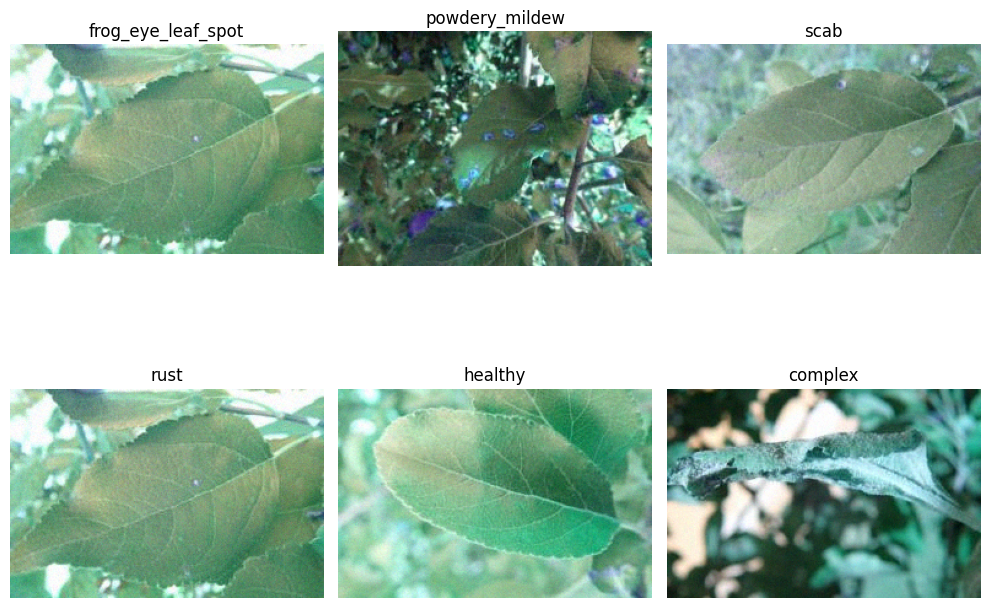

In [43]:
import matplotlib.pyplot as plt

# List of image filenames and corresponding titles
image_filenames = [gaus_frog_eye_leaf_spot[0], gaus_rust[0],
                   gaus_scab[0], gaus_complex[0],
                   gaus_healthy[0], gaus_powdery_mildew[0]]
image_titles = unique_labels

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Iterate over the image filenames, titles, and corresponding subplots
for i, (image_filename, image_title, ax) in enumerate(zip(image_filenames, image_titles, axes.flatten())):
    # Load the image
    image = plt.imread(image_filename)
    
    # Show the image in the subplot
    ax.imshow(image)
    ax.set_title(image_title)
    ax.axis('off')

# Adjust the layout of subplots to avoid overlapping
plt.tight_layout()

# Display the figure
plt.show()

# Label distribution after cutout and elastic transformation augmentation

In [44]:
# Reset the index 
train_df.reset_index(drop=True, inplace=True)
cutout_df.reset_index(drop=True, inplace=True)
elastic_transform_df.reset_index(drop=True, inplace=True)

# Concatenate the two dataframes vertically
combined_df = pd.concat([train_df, cutout_df, elastic_transform_df, gaus_df], axis=0)

# Reset the index of the combined dataframe
combined_df.reset_index(drop=True, inplace=True)

In [45]:
print("Original dataframe length:", len(train_df),
      "\nCutout dataframe length:", len(cutout_df),
      "\nElastic transform dataframe length:", len(elastic_transform_df),
      "\nGaussian noise dataframe length:", len(gaus_df))

print("------------------------------------------------------------")
print("Combined length:", len(combined_df))
print("____________________________________________________________")
print("Added length:", len(combined_df) - len(train_df))

Original dataframe length: 14884 
Cutout dataframe length: 1068 
Elastic transform dataframe length: 1068 
Gaussian noise dataframe length: 1068
------------------------------------------------------------
Combined length: 18088
____________________________________________________________
Added length: 3204


In [46]:
X_train = combined_df[['image']]
y_train = combined_df.drop('image', axis=1)
y_train = y_train.to_numpy()
y_train = y_train.astype(np.float32)

# Convert DataFrame column to NumPy array and change shape
X_train = X_train['image'].values.squeeze()

/tmp/ipykernel_17503/1826022811.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


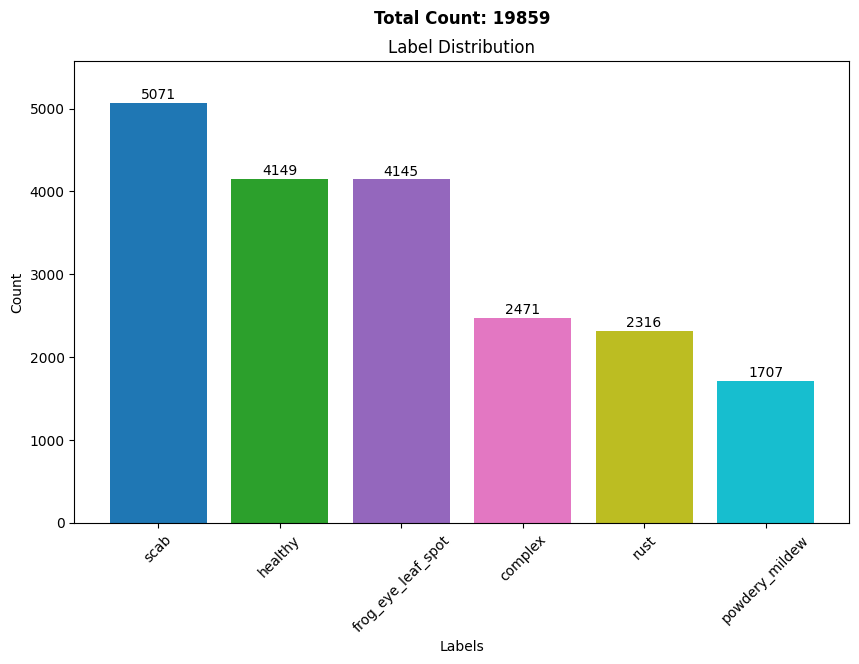

In [47]:
# Calculate the sum of each label column
label_counts = combined_df.iloc[:, 1:].sum()

# Define a colormap for assigning colors to labels
colormap = plt.cm.get_cmap('tab10')

# Get the number of unique labels
num_labels = len(label_counts)

# Generate an array of colors based on the colormap
colors = [colormap(i) for i in np.linspace(0, 1, num_labels)]

# Plot the label distribution with colored bars
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)

# Add count labels above the bars
for i, count in enumerate(label_counts):
    plt.text(i, count + 50, str(count), ha='center')

# Add a line below the total count
total_count = label_counts.sum()
plt.axhline(total_count, color='black', linestyle='--', alpha=0.5)

# Add total count of all labels above the title with increased font size and bold style
plt.text(0.5, 1.08, f'Total Count: {total_count}', transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')

# Calculate the maximum count for setting the y-axis limit
max_count = max(label_counts)
y_limit = max_count + max_count * 0.1  # Add some padding

plt.ylim(top=y_limit)  # Set the y-axis limit to accommodate the line

plt.show()

# Shape of training and validation after augmentation 

In [48]:
print('Shape of X_train : ',X_train.shape)
print('Shape of y_train : ',y_train.shape)
print('===============================================')
print('Shape of X_val : ',X_val.shape)
print('Shape of y_val : ',y_val.shape)

Shape of X_train :  (18088,)
Shape of y_train :  (18088, 6)
Shape of X_val :  (3721,)
Shape of y_val :  (3721, 6)


In [49]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [50]:
import tensorflow as tf
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Set the batch size and image size

In [51]:
if(strategy.num_replicas_in_sync != 1 ):
    print('TPU used')
    BATCH_SIZE = 48 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 1
    
print("Batch size:", BATCH_SIZE)

Batch size: 1


In [52]:
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = y_val.shape[0] // BATCH_SIZE

print ("Steps per epoch: ", STEPS_PER_EPOCH, "\nValidation steps: ", VALIDATION_STEPS)

Steps per epoch:  18088 
Validation steps:  3721


In [53]:
image_height = 380
image_width = 380

In [54]:
def decode_image(filename, label=None, image_size=(image_height, image_width)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_hue(image, max_delta=0.3)
    
    if label is None:
        return image
    else:
        return image, label

In [55]:
print(AUTO)

-1


In [56]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(decode_image, num_parallel_calls = AUTO)
    .map(data_augment, num_parallel_calls = AUTO)
    .repeat()
    .shuffle(256)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .map(decode_image, num_parallel_calls = AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# **Training** **model**

# Callback

In [57]:
tensorboard = TensorBoard(log_dir = 'logs')

checkpoint = ModelCheckpoint("effnet.h5", monitor="val_accuracy",save_best_only=True,
                             mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2, min_delta = 0.001,
                              mode='auto', verbose=1, min_lr=1e-9)

# Choosing to monitor val_accuracy since it is classification task and accuracy is more important
early_stop=EarlyStopping(monitor='val_accuracy', restore_best_weights= True,
                             patience=7, verbose=1)

filename='history.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)


callback_options = [tensorboard, checkpoint, reduce_lr, early_stop, history_logger]

# Transfer learning
In this notebook for training we are using **Transfer Learning** concept <br>

I will be using **EfficientNetB4** model with weights from **imagenet**. <br>
And I will using **include_top=False** option since it allows me to add my own output layer. <br>
And also i will freeze base model layers using ***effnet.trainable = False***<br>
**EfficientNetB4** model is used because *image size is *380x380*

The original image sizes used for every version of EfficientNet are:

    EfficientNetB0 - (224, 224, 3)
    EfficientNetB1 - (240, 240, 3)
    EfficientNetB2 - (260, 260, 3)
    EfficientNetB3 - (300, 300, 3)
    EfficientNetB4 - (380, 380, 3)
    EfficientNetB5 - (456, 456, 3)
    EfficientNetB6 - (528, 528, 3)
    EfficientNetB7 - (600, 600, 3)

In [58]:
effnet = Sequential([efn.EfficientNetB4(input_shape=(image_height, image_width,3), weights='noisy-student', include_top=False)])
# effnet.trainable = False

In [59]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(256,activation='relu')(model)
model = tf.keras.layers.Dense(128,activation='relu')(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(6,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b4_input (Inpu  [(None, 380, 380, 3)]    0         
 tLayer)                                                         
                                                                 
 efficientnet-b4 (Functional  (None, 12, 12, 1792)     17673816  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               459008    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [61]:
import json

# Count the number of occurrences for each label
label_counts = np.sum(y_train, axis=0)

# Calculate the class weights based on label frequencies
total_samples = y_train.shape[0]
class_weights = total_samples / (len(label_counts) * label_counts)

class_weights_dict = dict(zip(range(len(label_counts)), class_weights))

print(class_weights_dict)

{0: 0.59449154, 1: 0.72660077, 2: 0.72730196, 3: 1.2200189, 4: 1.3016696, 5: 1.7660613}


In [62]:
model.compile(loss='binary_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [63]:
history = model.fit(train_dataset,
                    epochs=30,
                    callbacks = callback_options,
                    class_weight=class_weights_dict,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/30


2023-05-25 02:48:01.359573: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-05-25 02:48:01.359713: E tensorflow/stream_executor/cuda/cuda_dnn.cc:398] Possibly insufficient driver version: 470.182.3
2023-05-25 02:48:01.360001: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops.cc:1134 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'model/efficientnet-b4/stem_conv/Conv2D' defined at (most recent call last):
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_17503/3930403656.py", line 1, in <module>
      history = model.fit(train_dataset,
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/enjoy/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/efficientnet-b4/stem_conv/Conv2D'
DNN library is not found.
	 [[{{node model/efficientnet-b4/stem_conv/Conv2D}}]] [Op:__inference_train_function_37650]

In [ ]:
history_df = pd.DataFrame(history.history)

# Save the training history as a CSV file
history_df.to_csv('training_history.csv', index=False)

In [ ]:
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,7))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['training','validation'])
ax1.set_title('loss')
ax1.set_xlabel('epoch')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['training','validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('epoch')

In [ ]:
# Access the best epoch and corresponding accuracy value
best_epoch = early_stop.stopped_epoch + 1
best_accuracy = max(history.history['val_accuracy'])

# Print the best epoch and accuracy value
print(f"Best Epoch: {best_epoch}")
print(f"Best Accuracy: {best_accuracy}")

# Prediction

In [ ]:
SUB_PATH = "../input/plant-pathology-2021-fgvc8/sample_submission.csv"
sub_df = pd.read_csv(SUB_PATH)

def format_test_path(st):
    return '/kaggle/input/plant-pathology-2021-fgvc8/test_images/' + st

def format_own_path(st):
    return '/kaggle/input/own-pictures' + st

test_paths = sub_df.image.apply(format_test_path).values

In [ ]:
# Transform the labels into a binary matrix with one-hot encoding for the six common labels
label_matrix = mlb.fit_transform(sub_df['labels'].str.split())

# Create a new dataframe with the one-hot encoded labels
label_df = pd.DataFrame(label_matrix, columns=common_labels)

# fixes train_df row number error
sub_df.reset_index(drop=True, inplace=True)
label_df.reset_index(drop=True, inplace=True)

# Concatenate the new label dataframe with the original dataframe
new_df = pd.concat([sub_df, label_df], axis=1)

# Drop the original labels column from the new dataframe
sub_df = new_df.drop('labels', axis=1)
sub_df.head()

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
probs_efn = model.predict(test_dataset, verbose=1)

In [ ]:
sub_df.loc[:, 'scab':] = probs_efn
sub_df.to_csv('prediction.csv', index=False)
sub_df.head()

# Making predictions with my own pictures

In [ ]:
# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('/kaggle/input/model-from-46-version/effnet.h5')
model.summary()

In [ ]:
image_dir = "/kaggle/input/own-pictures-new"  # Directory path containing the images

image_paths = []  # Array to store the image paths
image_names = []

# Iterate over each file in the directory
for file in os.listdir(image_dir):
    # Check if the file is an image file
    image_path = os.path.join(image_dir, file)
        
    # Append the image path to the array
    image_paths.append(image_path)
    image_names.append(file)

In [ ]:
 BATCH_SIZE = 80 * 4

own_dataset = (
    tf.data.Dataset
    .from_tensor_slices(image_paths)
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
probs_own = model.predict(own_dataset, verbose=1)

In [ ]:
probs_own

In [ ]:
df1 = pd.DataFrame({'Column1': image_names})
df2 = pd.DataFrame(probs_own, columns=common_labels)

df = pd.concat([df1, df2], axis=1)

df

In [ ]:
# Recreate the exact same model, including weights and optimizer.
model_26_88acc = tf.keras.models.load_model('/kaggle/input/model-from-46-version/version_26_88acc.h5')
model_26_88acc.summary()

In [ ]:
probs_own = model_26_88acc.predict(own_dataset, verbose=1)

In [ ]:
probs_own

In [ ]:
df1 = pd.DataFrame({'Column1': image_names})
df2 = pd.DataFrame(probs_own, columns=common_labels)

df = pd.concat([df1, df2], axis=1)

df.iloc[:1]